In [11]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.graph_objects as go
import re
import io

# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import plotly.io as pio

# Setting some parameters
warnings.filterwarnings("ignore")

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns = 300
pd.options.display.max_rows = 1000

**Defining functions**

In [2]:
print("VALIDATION directory path: {}".format(here()))

VALIDATION directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


In [3]:
#### We want to explore data characteristics ACROSS only VALIDATION? also VALDIATION / EXCLUDED / EXTERNAL?

**Load data**

In [4]:
# Load the annotated file
adata = sc.read_h5ad(here("01_data_processing/results/02_INFLAMMATION_validation_afterQC.h5ad"))
# adata = sc.read_h5ad(here("02_fromCellLineages_to_CellTypes/01_INFLAMMATION_VALIDATION_normalized_annotated.h5ad")) # annotated, therefore cleaned
adata.uns['log1p'] = dict()
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 849922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors', 'log1p'

## Cell Exploration

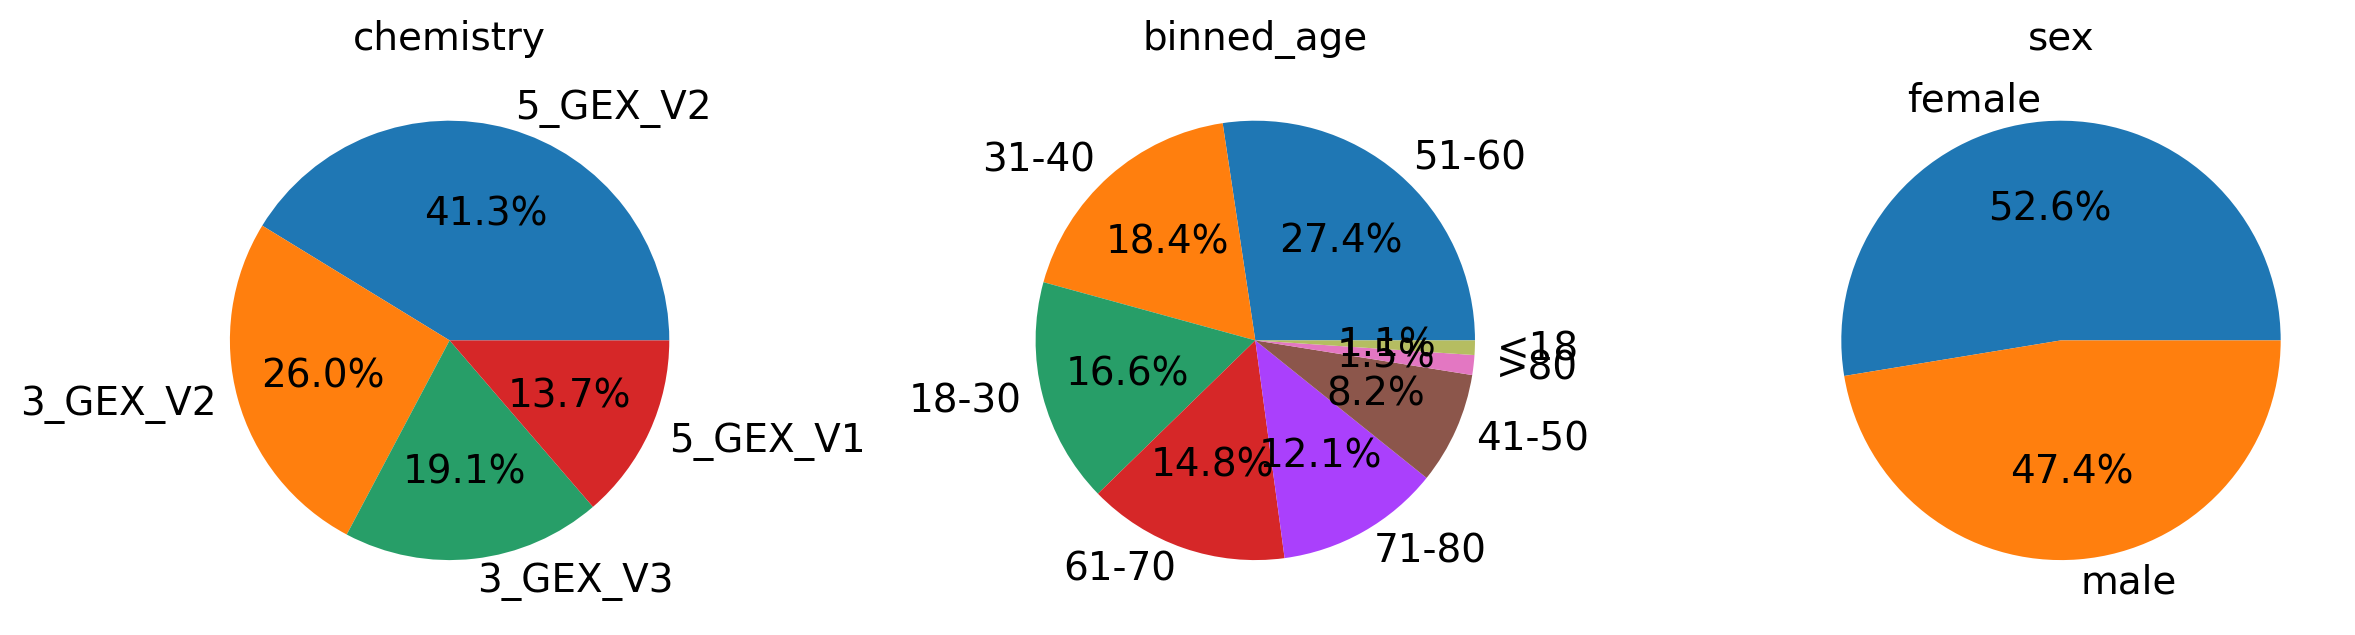

In [5]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    counts = adata.obs[variable].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

# Patient exploration

In [7]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

,studyID,patientID,chemistry,technology,binned_age,sex,disease,studyID_disease
21,SCGT00,SCGT00_I020013,3_GEX_V3,3_GEX_V3_GenoHashed,71-80,male,CD,CD_SCGT00
15,SCGT00,SCGT00_I012032,3_GEX_V3,3_GEX_V3_GenoHashed,51-60,female,CD,CD_SCGT00
14,SCGT00,SCGT00_I012014,3_GEX_V3,3_GEX_V3_GenoHashed,41-50,female,CD,CD_SCGT00
13,SCGT00,SCGT00_I0124,3_GEX_V3,3_GEX_V3_GenoHashed,18-30,female,CD,CD_SCGT00
19,SCGT00,SCGT00_I0208,3_GEX_V3,3_GEX_V3_GenoHashed,41-50,female,CD,CD_SCGT00


In [8]:
obs_df['sex'] = pd.Categorical(obs_df['sex'], categories=['male', 'female'])
obs_df['binned_age'] = pd.Categorical(obs_df['binned_age'], categories=['<18',  '18-30', '31-40', '41-50', '51-60','61-70', '71-80', '>80', 'unknown'])
obs_df['binned_age'] = obs_df['binned_age'].fillna('unknown')

# Replace 
obs_df['studyID'] = obs_df['studyID'].replace('Zhang2023', 'Zhang2022')

obs_df['disease'] = obs_df['disease'].astype(str)
obs_df['patientID'] = obs_df['patientID'].astype(str)

# Calculate total patientID by disease
total_patientID_by_disease = obs_df.groupby('disease')['patientID'].count().reset_index()
total_patientID_by_disease.columns = ['disease', 'total_patientID']

# Merge total_patientID_by_disease back to obs_df
obs_df = pd.merge(obs_df, total_patientID_by_disease, on='disease')

# Mapping diseases to diseaseGroup
obs_df['diseaseGroup'] = obs_df['disease'].map(diseaseCategories)
obs_df['diseaseGroup'] = pd.Categorical(obs_df['diseaseGroup'], categories=diseaseGroup_sortednames, ordered=True)

# Sort obs_df by diseaseGroup in the order specified by diseaseGroup_sortednames, and then by total_patientID ascending
obs_df = obs_df.sort_values(by=['diseaseGroup', 'total_patientID'], ascending=[True, False])

# Convert disease to categorical with the correct order
obs_df['disease'] = pd.Categorical(obs_df['disease'], categories=obs_df['disease'].unique())

# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)


# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)

In [9]:
# Helper function to calculate percentages
def calculate_percentage(df, group_by_cols):
    count_data = df.groupby(group_by_cols).size().reset_index(name='Patient Count')
    total_counts = count_data.groupby(group_by_cols[0])['Patient Count'].transform('sum')
    count_data['Percentage'] = (count_data['Patient Count'] / total_counts) * 100
    return count_data

# Plotting function for stacked bar plots with percentages
def plot_percentage_stacked_bar(ax, x, y, data, title, palette, **kwargs):
    # Pivot the data
    pivot_data = data.pivot_table(index=y, columns=x, values='Percentage', fill_value=0)

    # Extract bar height from kwargs or set a default value
    bar_height = kwargs.pop('height', 0.8)

    # Plot the data with specified bar height
    left = np.zeros(len(pivot_data))
    legend_handles = []
    for column in pivot_data.columns:
        ax.barh(pivot_data.index, pivot_data[column], left=left, height=bar_height, label=column, color=palette[column], **kwargs)
        left += pivot_data[column]
        legend_handles.append(Patch(facecolor=palette[column], edgecolor='black', label=column))
        
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('' if ax != axes[0] else 'Disease')

    # Remove grid
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', rotation=90)
    ax.yaxis.grid(False)

    # Set legend
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2, frameon=False, handles=legend_handles)

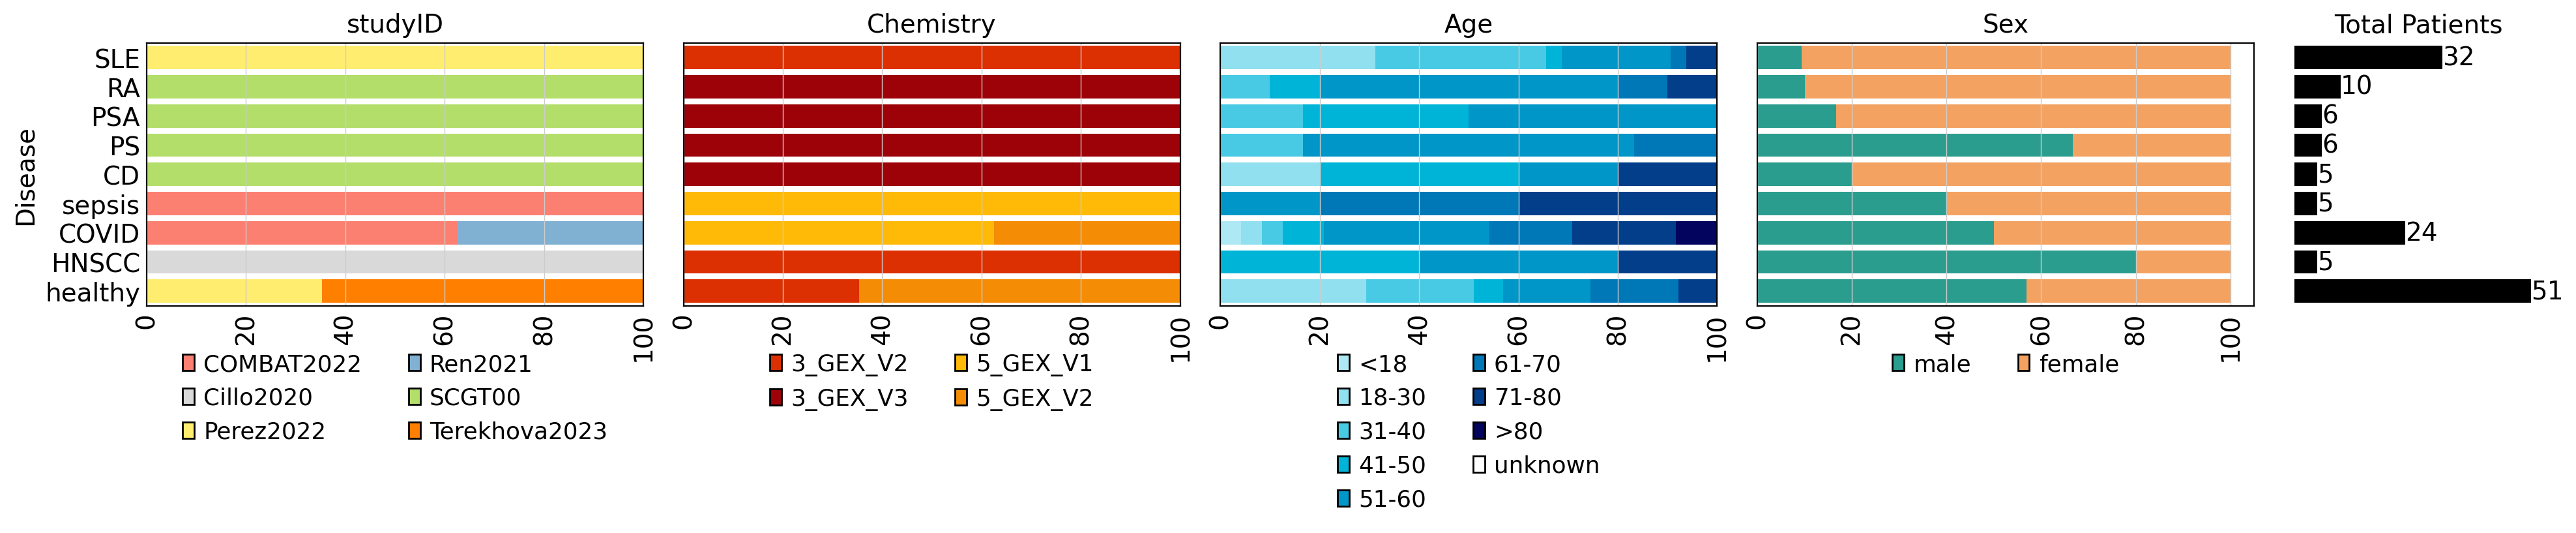

In [18]:
# Calculate percentages
agg_data_studyID = calculate_percentage(obs_df, ['disease', 'studyID'])
agg_data_chemistry = calculate_percentage(obs_df, ['disease', 'chemistry'])
agg_data_binned_age = calculate_percentage(obs_df, ['disease', 'binned_age'])
agg_data_sex = calculate_percentage(obs_df, ['disease', 'sex'])
total_per_disease = obs_df.groupby('disease').size().reset_index(name='Total Patients')

# Create a figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4.5), sharey=True, 
                         gridspec_kw={'width_ratios': [3, 3, 3, 3, 1.5]})

# Plot stacked bar plots for each category
plot_percentage_stacked_bar(axes[0], 'studyID', 'disease', agg_data_studyID, 'studyID', palette=studyID_palette)
plot_percentage_stacked_bar(axes[1], 'chemistry', 'disease', agg_data_chemistry, 'Chemistry', palette=chemistry_palette)
plot_percentage_stacked_bar(axes[2], 'binned_age', 'disease', agg_data_binned_age, 'Age', palette=binned_age_palette)
plot_percentage_stacked_bar(axes[3], 'sex', 'disease', agg_data_sex, 'Sex', palette=sex_palette)

# Plot total patients per disease
sns.barplot(ax=axes[4], x='Total Patients', y='disease', data=total_per_disease, orient='h', color="black")
axes[4].set_title('Total Patients')
axes[4].bar_label(axes[4].containers[0])
axes[4].axis('off')

# Adjust layout
plt.tight_layout(w_pad=0, h_pad=0.1)
plt.show()

fig.savefig(here(f"01_data_processing/figures/VALIDATIONdata_ClinicalMetadata_overview.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [26]:
# For table

counts = obs_df[["disease", "binned_age", "sex"]].value_counts().reset_index(name='count').sort_values(by=['disease', 'binned_age'], ascending=[True, True])
pivot_table = counts.pivot_table(index='disease', columns=['binned_age', 'sex'], values='count') # , fill_value=0
pivot_table = pivot_table.reindex(disease_sortednames)
pivot_table

binned_age  <18        18-30        31-40        41-50        51-60         \
sex        male female  male female  male female  male female  male female   
disease                                                                      
RA          NaN    NaN   NaN    4.0   NaN    5.0   NaN    6.0   1.0   13.0   
PS          NaN    NaN   2.0    1.0   2.0    NaN   5.0    3.0   4.0    6.0   
PSA         NaN    NaN   1.0    NaN   NaN    3.0   4.0    6.0   2.0    4.0   
CD          NaN    NaN   3.0    NaN   3.0    2.0   2.0    4.0   NaN    4.0   
UC          NaN    NaN   3.0    3.0   1.0    2.0   4.0    2.0   3.0    NaN   
SLE         NaN    NaN   1.0   27.0   3.0   30.0   5.0   27.0   1.0   29.0   
MS          NaN    NaN   NaN    1.0   NaN    1.0   1.0    2.0   NaN    NaN   
sepsis      NaN    NaN   2.0    NaN   NaN    NaN   2.0    3.0   7.0    NaN   
asthma      NaN    NaN   NaN    NaN   NaN    NaN   2.0    NaN   4.0    2.0   
COPD        NaN    NaN   NaN    NaN   NaN    NaN   NaN    NaN   1.0    2.0   
cirrhosis   NaN    NaN   NaN    NaN   NaN    NaN   1.0    NaN   3.0    NaN   
HIV         NaN    NaN   NaN    NaN   2.0    NaN   NaN    NaN   4.0    NaN   
HBV         NaN    NaN   3.0    NaN   2.0    2.0   6.0    NaN   NaN    1.0   
COVID       2.0    1.0   1.0    1.0  10.0    6.0  14.0    7.0  22.0   12.0   
flu         NaN    NaN   NaN    NaN   NaN    2.0   2.0    NaN   2.0    1.0   
BRCA        NaN    NaN   NaN    NaN   NaN    2.0   NaN    2.0   NaN    2.0   
NPC         NaN    NaN   1.0    NaN   NaN    NaN   3.0    NaN   4.0    NaN   
HNSCC       NaN    NaN   NaN    NaN   1.0    NaN   4.0    NaN   3.0    1.0   
CRC         NaN    NaN   NaN    NaN   NaN    NaN   1.0    NaN   1.0    2.0   
healthy     NaN    NaN  24.0   35.0  29.0   36.0  19.0   15.0  20.0   18.0   

binned_age 61-70        71-80         >80        unknown  
sex         male female  male female male female    male  
disease                                                   
RA           1.0    7.0   NaN    1.0  NaN    NaN     NaN  
PS           NaN    1.0   NaN    2.0  NaN    NaN     NaN  
PSA          1.0    4.0   NaN    1.0  NaN    NaN     NaN  
CD           1.0    2.0   NaN    NaN  NaN    NaN     NaN  
UC           1.0    NaN   NaN    3.0  NaN    NaN     NaN  
SLE          1.0   16.0   NaN    1.0  1.0    NaN     NaN  
MS           NaN    NaN   NaN    NaN  NaN    NaN     NaN  
sepsis       5.0    3.0   5.0    2.0  4.0    2.0     NaN  
asthma       3.0    1.0   NaN    NaN  NaN    NaN     NaN  
COPD         2.0    1.0   3.0    3.0  NaN    NaN     NaN  
cirrhosis    2.0    1.0   NaN    1.0  NaN    NaN     NaN  
HIV          NaN    NaN   NaN    NaN  NaN    NaN     NaN  
HBV          NaN    NaN   NaN    NaN  NaN    NaN     1.0  
COVID        8.0    8.0  12.0    5.0  4.0    4.0     NaN  
flu          2.0    1.0   NaN    NaN  1.0    NaN     NaN  
BRCA         NaN    NaN   NaN    NaN  NaN    NaN     NaN  
NPC          2.0    NaN   NaN    NaN  NaN    NaN     NaN  
HNSCC        5.0    2.0   3.0    2.0  NaN    NaN     NaN  
CRC          2.0    1.0   2.0    2.0  1.0    2.0     NaN  
healthy     22.0   14.0  20.0   16.0  1.0    1.0     NaN

In [6]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

,studyID,patientID,chemistry,technology,binned_age,sex,disease,studyID_disease
21,SCGT00,SCGT00_I020013,3_GEX_V3,3_GEX_V3_GenoHashed,71-80,male,CD,CD_SCGT00
15,SCGT00,SCGT00_I012032,3_GEX_V3,3_GEX_V3_GenoHashed,51-60,female,CD,CD_SCGT00
14,SCGT00,SCGT00_I012014,3_GEX_V3,3_GEX_V3_GenoHashed,41-50,female,CD,CD_SCGT00
13,SCGT00,SCGT00_I0124,3_GEX_V3,3_GEX_V3_GenoHashed,18-30,female,CD,CD_SCGT00
19,SCGT00,SCGT00_I0208,3_GEX_V3,3_GEX_V3_GenoHashed,41-50,female,CD,CD_SCGT00


In [7]:
counts = obs_df[["disease", "binned_age", "sex"]].value_counts().reset_index(name='count').sort_values(by=['disease', 'binned_age'], ascending=[True, True])
pivot_table = counts.pivot_table(index='disease', columns=['binned_age', 'sex'], values='count') # , fill_value=0
pivot_table = pivot_table.reindex(disease_sortednames)
pivot_table

binned_age    <18  18-30       31-40       41-50       51-60       61-70       \
sex        female female male female male female male female male female male   
disease                                                                         
RA            NaN    NaN  NaN    1.0  NaN    1.0  NaN    5.0  1.0    1.0  NaN   
PS            NaN    NaN  NaN    NaN  1.0    NaN  NaN    2.0  2.0    NaN  1.0   
PSA           NaN    NaN  NaN    1.0  NaN    2.0  NaN    2.0  1.0    NaN  NaN   
CD            NaN    1.0  NaN    NaN  NaN    2.0  NaN    1.0  NaN    NaN  NaN   
UC            NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
SLE           NaN    8.0  2.0   11.0  NaN    1.0  NaN    6.0  1.0    1.0  NaN   
MS            NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
sepsis        NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  1.0    2.0  NaN   
asthma        NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
COPD          NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
cirrhosis     NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
HIV           NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
HBV           NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
COVID         1.0    NaN  1.0    NaN  1.0    1.0  1.0    4.0  4.0    2.0  2.0   
flu           NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
BRCA          NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
NPC           NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
HNSCC         NaN    NaN  NaN    NaN  NaN    NaN  2.0    1.0  1.0    NaN  NaN   
CRC           NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN    NaN  NaN   
healthy       NaN   11.0  4.0    4.0  7.0    1.0  2.0    4.0  5.0    1.0  8.0   

binned_age  71-80         >80       
sex        female male female male  
disease                             
RA            1.0  NaN    NaN  NaN  
PS            NaN  NaN    NaN  NaN  
PSA           NaN  NaN    NaN  NaN  
CD            NaN  1.0    NaN  NaN  
UC            NaN  NaN    NaN  NaN  
SLE           2.0  NaN    NaN  NaN  
MS            NaN  NaN    NaN  NaN  
sepsis        1.0  1.0    NaN  NaN  
asthma        NaN  NaN    NaN  NaN  
COPD          NaN  NaN    NaN  NaN  
cirrhosis     NaN  NaN    NaN  NaN  
HIV           NaN  NaN    NaN  NaN  
HBV           NaN  NaN    NaN  NaN  
COVID         3.0  2.0    1.0  1.0  
flu           NaN  NaN    NaN  NaN  
BRCA          NaN  NaN    NaN  NaN  
NPC           NaN  NaN    NaN  NaN  
HNSCC         NaN  1.0    NaN  NaN  
CRC           NaN  NaN    NaN  NaN  
healthy       1.0  3.0    NaN  NaN

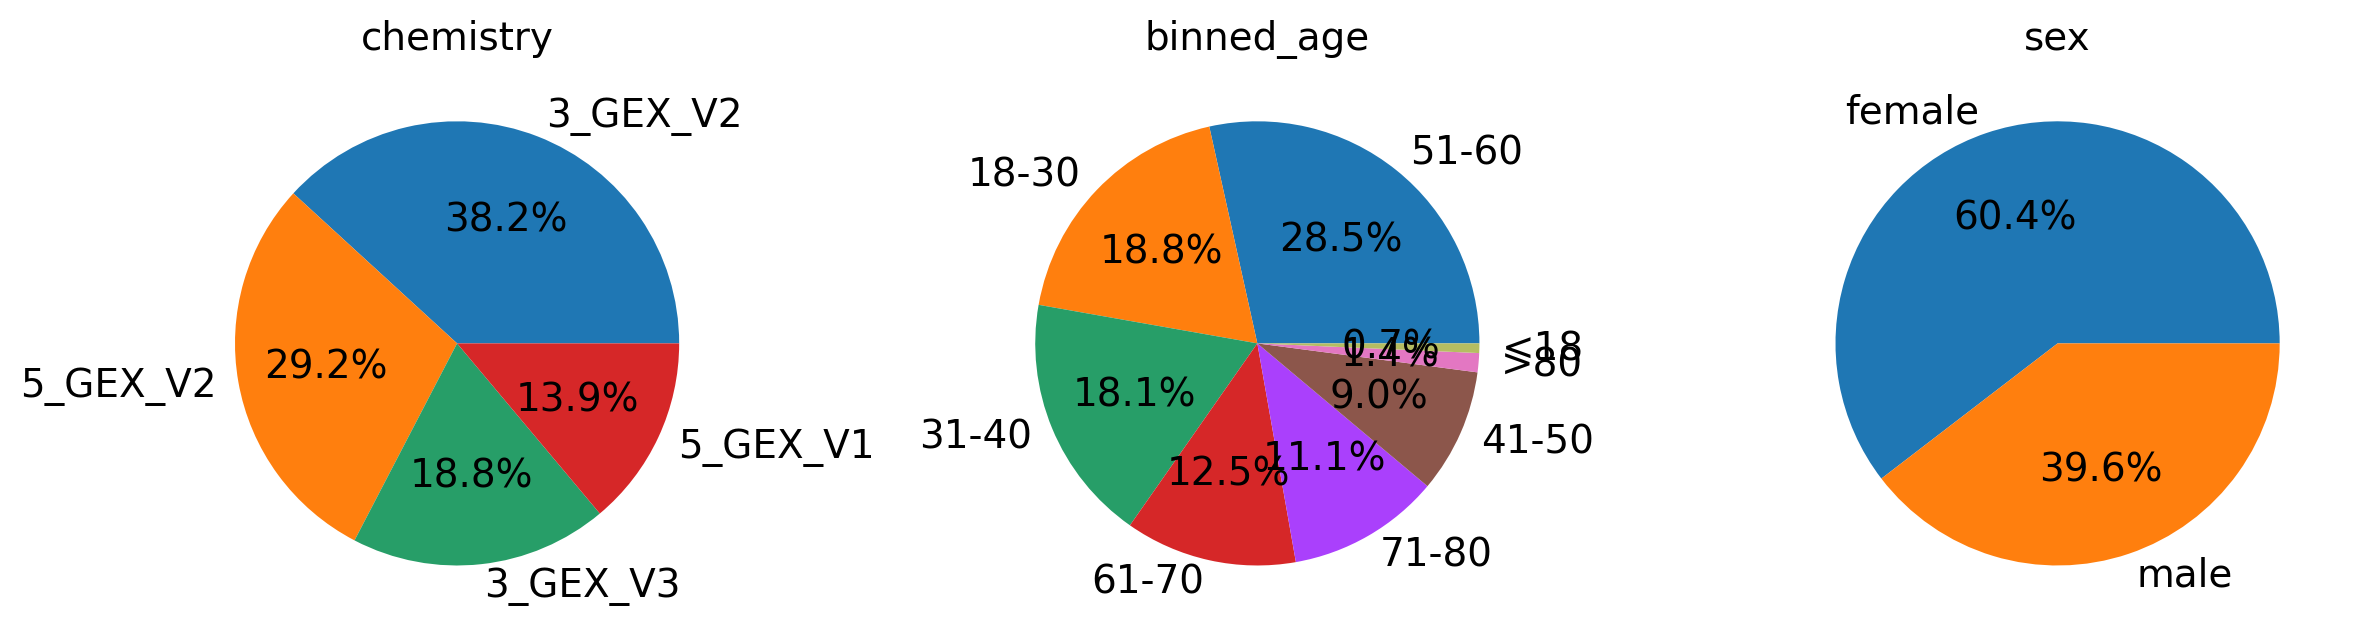

In [9]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    counts = obs_df[variable].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
session_info.show()